In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== STEP 1: DATA LOADING ===")
print("Loading the datasets...")

# File paths
trader_file = r"C:\Users\USER\Downloads\hyperliquid_trader_data.csv"
sentiment_file = r"C:\Users\USER\Downloads\fear_greed_index.csv"

try:
    # Load trader data
    trader_data = pd.read_csv(trader_file, low_memory=False)
    print(f" Trader data loaded successfully! Shape: {trader_data.shape}")
    
    # Load sentiment data
    sentiment_data = pd.read_csv(sentiment_file, low_memory=False)
    print(f" Sentiment data loaded successfully! Shape: {sentiment_data.shape}")
    
    # Display column information
    print(f"\nTrader Data Columns: {trader_data.columns.tolist()}")
    print(f"Sentiment Data Columns: {sentiment_data.columns.tolist()}")
    
    # Show sample data
    print(f"\nTrader Data Sample:")
    print(trader_data.head(2))
    print(f"\nSentiment Data Sample:")
    print(sentiment_data.head(2))
    
    print("\n STEP 1 COMPLETED SUCCESSFULLY!")
    
except Exception as e:
    print(f" Error in Step 1: {str(e)}")
    print("Please check your file paths and try again.")

=== STEP 1: DATA LOADING ===
Loading the datasets...
 Trader data loaded successfully! Shape: (211224, 16)
 Sentiment data loaded successfully! Shape: (2644, 4)

Trader Data Columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
Sentiment Data Columns: ['timestamp', 'value', 'classification', 'date']

Trader Data Sample:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   

   Closed PnL                                   Transaction Has

In [6]:
# Run this after Step 1
print("\n=== STEP 2: DATA PREPROCESSING ===")
print("Cleaning and preparing the data...")

try:
    # Process trader data - handle different possible column names
    print("\nProcessing Trader Data...")
    
    # Handle time column
    time_cols = [col for col in trader_data.columns if 'time' in col.lower()]
    if time_cols:
        time_col = time_cols[0]
        trader_data[time_col] = pd.to_datetime(trader_data[time_col], errors='coerce')
        trader_data['date'] = trader_data[time_col].dt.date
        print(f" Using time column: {time_col}")
    
    # Handle account column (case-insensitive)
    account_cols = [col for col in trader_data.columns if 'account' in col.lower()]
    if account_cols:
        account_col = account_cols[0]
        trader_data['account'] = trader_data[account_col]
        print(f" Using account column: {account_col}")
    
    # Handle PnL column
    pnl_cols = [col for col in trader_data.columns if 'pnl' in col.lower() or 'profit' in col.lower()]
    if pnl_cols:
        pnl_col = pnl_cols[0]
        trader_data['closedPnL'] = trader_data[pnl_col]
        trader_data['profitable_trade'] = trader_data['closedPnL'] > 0
        print(f" Using PnL column: {pnl_col}")
    
    # Handle price and size columns
    price_cols = [col for col in trader_data.columns if 'price' in col.lower()]
    size_cols = [col for col in trader_data.columns if 'size' in col.lower() and 'usd' not in col.lower()]
    
    if price_cols and size_cols:
        price_col = price_cols[0]
        size_col = size_cols[0]
        trader_data['execution_price'] = trader_data[price_col]
        trader_data['size'] = trader_data[size_col]
        trader_data['trade_value'] = abs(trader_data['execution_price'] * trader_data['size'])
        print(f" Using price column: {price_col}, size column: {size_col}")
    
    # Handle leverage (create default if not exists)
    leverage_cols = [col for col in trader_data.columns if 'leverage' in col.lower()]
    if leverage_cols:
        leverage_col = leverage_cols[0]
        trader_data['leverage'] = trader_data[leverage_col]
        print(f" Using leverage column: {leverage_col}")
    else:
        trader_data['leverage'] = 1.0
        print(" No leverage column found, using default value of 1.0")
    
    print("\nProcessing Sentiment Data...")
    
    # Handle date column
    date_cols = [col for col in sentiment_data.columns if 'date' in col.lower()]
    if date_cols:
        date_col = date_cols[0]
        sentiment_data[date_col] = pd.to_datetime(sentiment_data[date_col], errors='coerce')
        sentiment_data['date'] = sentiment_data[date_col].dt.date
        print(f" Using date column: {date_col}")
    
    # Handle sentiment classification column
    sentiment_cols = [col for col in sentiment_data.columns if any(x in col.lower() for x in ['classification', 'sentiment'])]
    if sentiment_cols:
        sentiment_col = sentiment_cols[0]
        sentiment_data['Classification'] = sentiment_data[sentiment_col]
        print(f" Using sentiment column: {sentiment_col}")
    
    # Clean data - remove rows with missing critical information
    print(f"\nCleaning Data...")
    initial_trader_rows = len(trader_data)
    trader_data_clean = trader_data.dropna(subset=['date', 'closedPnL', 'account']).copy()
    print(f" Trader data: Removed {initial_trader_rows - len(trader_data_clean)} rows with missing data")
    
    initial_sentiment_rows = len(sentiment_data)
    sentiment_data_clean = sentiment_data.dropna(subset=['date', 'Classification']).copy()
    print(f"* Sentiment data: Removed {initial_sentiment_rows - len(sentiment_data_clean)} rows with missing data")
    
    print(f"\nFinal Data Shapes:")
    print(f"* Clean Trader Data: {trader_data_clean.shape}")
    print(f"* Clean Sentiment Data: {sentiment_data_clean.shape}")
    
    # Show date ranges
    print(f"\nDate Ranges:")
    print(f"* Trader Data: {trader_data_clean['date'].min()} to {trader_data_clean['date'].max()}")
    print(f"* Sentiment Data: {sentiment_data_clean['date'].min()} to {sentiment_data_clean['date'].max()}")
    
    print(f"\n STEP 2 COMPLETED SUCCESSFULLY!")
    
except Exception as e:
    print(f" Error in Step 2: {str(e)}")
    print("Please check the data and try again.")


=== STEP 2: DATA PREPROCESSING ===
Cleaning and preparing the data...

Processing Trader Data...
 Using time column: Timestamp IST
 Using account column: Account
 Using PnL column: Closed PnL
 Using price column: Execution Price, size column: Size Tokens
 No leverage column found, using default value of 1.0

Processing Sentiment Data...
 Using date column: date
 Using sentiment column: classification

Cleaning Data...
 Trader data: Removed 131999 rows with missing data
* Sentiment data: Removed 0 rows with missing data

Final Data Shapes:
* Clean Trader Data: (79225, 24)
* Clean Sentiment Data: (2644, 5)

Date Ranges:
* Trader Data: 2023-01-05 to 2025-12-04
* Sentiment Data: 2018-02-01 to 2025-05-02

 STEP 2 COMPLETED SUCCESSFULLY!


In [7]:
# Run this after Step 2
print("\n=== STEP 3: DATA MERGING ===")
print("Combining trader data with sentiment data...")

try:
    # Create daily trader statistics
    print("Creating daily trader statistics...")
    
    daily_trader_stats = trader_data_clean.groupby(['date', 'account']).agg({
        'closedPnL': ['sum', 'count', 'mean'],
        'profitable_trade': 'mean',
        'trade_value': 'sum',
        'leverage': 'mean'
    }).reset_index()
    
    # Flatten column names
    daily_trader_stats.columns = [
        'date', 'account', 'total_pnl', 'num_trades', 
        'avg_pnl', 'win_rate', 'total_volume', 'avg_leverage'
    ]
    
    print(f" Daily trader stats created: {daily_trader_stats.shape}")
    
    # Merge with sentiment data
    print("Merging with sentiment data...")
    
    merged_data = daily_trader_stats.merge(
        sentiment_data_clean[['date', 'Classification']], 
        on='date', 
        how='inner'
    )
    
    print(f" Data merged successfully!")
    print(f" Merged dataset shape: {merged_data.shape}")
    print(f" Unique traders: {merged_data['account'].nunique()}")
    print(f" Date range: {merged_data['date'].min()} to {merged_data['date'].max()}")
    
    # Show sentiment distribution
    print(f"\nSentiment Distribution:")
    sentiment_counts = merged_data['Classification'].value_counts()
    for sentiment, count in sentiment_counts.items():
        print(f" {sentiment}: {count} trader-days ({count/len(merged_data)*100:.1f}%)")
    
    # Show basic statistics
    print(f"\nBasic Statistics:")
    print(f" Total PnL in dataset: ${merged_data['total_pnl'].sum():,.2f}")
    print(f" Average daily PnL per trader: ${merged_data['total_pnl'].mean():.2f}")
    print(f" Average win rate: {merged_data['win_rate'].mean():.2%}")
    print(f" Total volume: ${merged_data['total_volume'].sum():,.2f}")
    
    print(f"\n✓ STEP 3 COMPLETED SUCCESSFULLY!")
    
except Exception as e:
    print(f" Error in Step 3: {str(e)}")
    print("Please check the previous steps and try again.")


=== STEP 3: DATA MERGING ===
Combining trader data with sentiment data...
Creating daily trader statistics...
 Daily trader stats created: (907, 8)
Merging with sentiment data...
 Data merged successfully!
 Merged dataset shape: (530, 9)
 Unique traders: 32
 Date range: 2023-01-05 to 2025-05-02

Sentiment Distribution:
 Greed: 191 trader-days (36.0%)
 Fear: 157 trader-days (29.6%)
 Extreme Greed: 112 trader-days (21.1%)
 Neutral: 37 trader-days (7.0%)
 Extreme Fear: 33 trader-days (6.2%)

Basic Statistics:
 Total PnL in dataset: $3,624,808.47
 Average daily PnL per trader: $6839.26
 Average win rate: 33.45%
 Total volume: $176,463,758.17

✓ STEP 3 COMPLETED SUCCESSFULLY!



=== STEP 4: BASIC ANALYSIS & VISUALIZATIONS ===
Creating visualizations to explore the data...
 Creating PnL distribution plot...
 Creating win rate analysis...
 Creating volume analysis...
 Creating trade frequency analysis...
 Creating leverage analysis...
 Creating correlation matrix...


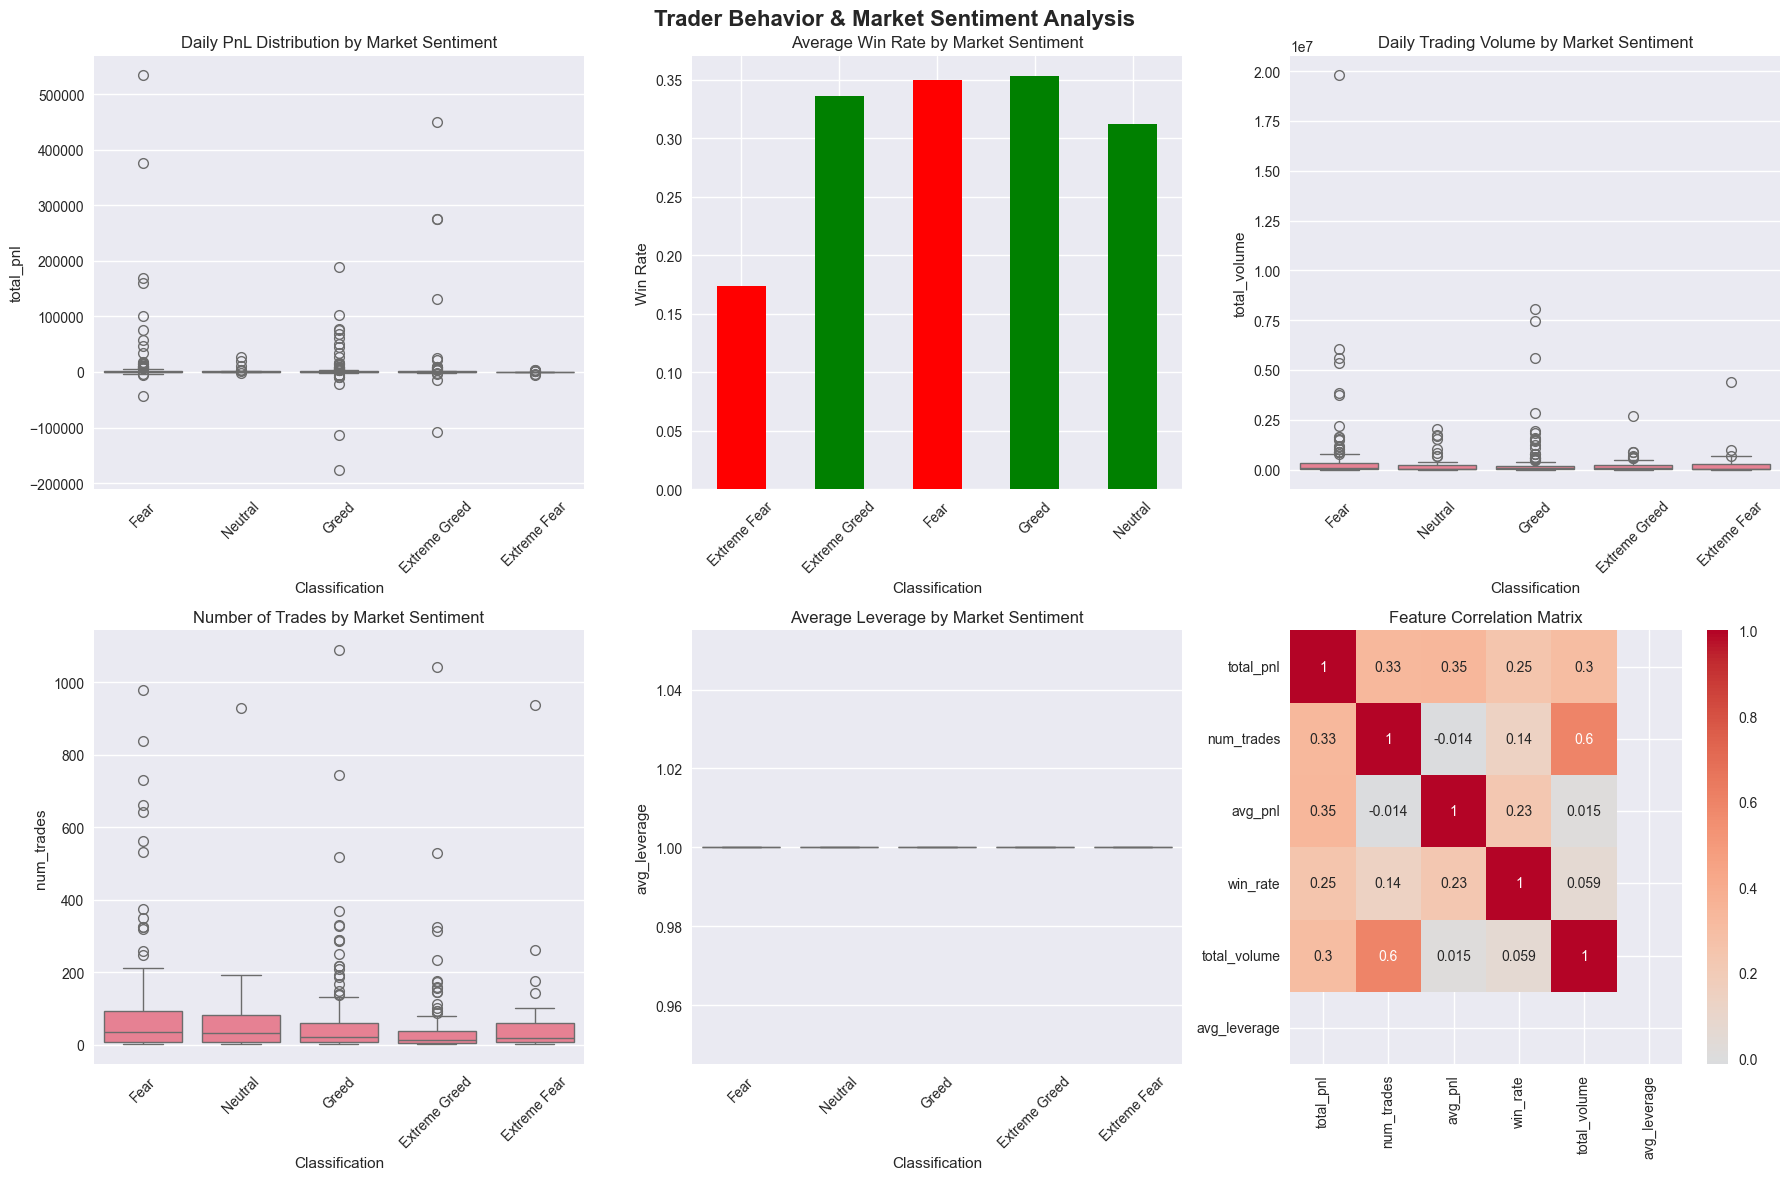


=== STATISTICAL SUMMARY BY SENTIMENT ===
                 total_pnl                             win_rate          \
                      mean    median         std count     mean  median   
Classification                                                            
Extreme Fear      133.3314    0.0000   1550.0321    33   0.1735  0.0000   
Extreme Greed   10329.4078  108.9390  57886.5338   112   0.3359  0.2472   
Fear            11332.6470  396.0627  55888.1227   157   0.3499  0.3382   
Greed            3191.7934  147.4458  24776.2317   191   0.3531  0.3240   
Neutral          2017.7498   87.7522   5609.7005    37   0.3125  0.2105   

                       total_volume                           avg_leverage  \
                   std         mean      median           std         mean   
Classification                                                               
Extreme Fear    0.2670  290310.3087  45002.6607  7.752168e+05          1.0   
Extreme Greed   0.3629  162712.1437  74302.19

In [8]:
# Run this after Step 3
print("\n=== STEP 4: BASIC ANALYSIS & VISUALIZATIONS ===")
print("Creating visualizations to explore the data...")

try:
    # Create comprehensive visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Trader Behavior & Market Sentiment Analysis', fontsize=16, fontweight='bold')
    
    # 1. PnL Distribution by Sentiment
    print(" Creating PnL distribution plot...")
    sns.boxplot(data=merged_data, x='Classification', y='total_pnl', ax=axes[0,0])
    axes[0,0].set_title('Daily PnL Distribution by Market Sentiment')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Win Rate by Sentiment
    print(" Creating win rate analysis...")
    win_rate_by_sentiment = merged_data.groupby('Classification')['win_rate'].mean()
    colors = ['red' if 'Fear' in x else 'green' for x in win_rate_by_sentiment.index]
    win_rate_by_sentiment.plot(kind='bar', ax=axes[0,1], color=colors)
    axes[0,1].set_title('Average Win Rate by Market Sentiment')
    axes[0,1].set_ylabel('Win Rate')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Trading Volume by Sentiment
    print(" Creating volume analysis...")
    sns.boxplot(data=merged_data, x='Classification', y='total_volume', ax=axes[0,2])
    axes[0,2].set_title('Daily Trading Volume by Market Sentiment')
    axes[0,2].tick_params(axis='x', rotation=45)
    
    # 4. Number of Trades by Sentiment
    print(" Creating trade frequency analysis...")
    sns.boxplot(data=merged_data, x='Classification', y='num_trades', ax=axes[1,0])
    axes[1,0].set_title('Number of Trades by Market Sentiment')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 5. Leverage Usage by Sentiment
    print(" Creating leverage analysis...")
    sns.boxplot(data=merged_data, x='Classification', y='avg_leverage', ax=axes[1,1])
    axes[1,1].set_title('Average Leverage by Market Sentiment')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # 6. Correlation Heatmap
    print(" Creating correlation matrix...")
    numerical_cols = ['total_pnl', 'num_trades', 'avg_pnl', 'win_rate', 'total_volume', 'avg_leverage']
    correlation_matrix = merged_data[numerical_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,2])
    axes[1,2].set_title('Feature Correlation Matrix')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistical summary
    print(f"\n=== STATISTICAL SUMMARY BY SENTIMENT ===")
    
    summary_stats = merged_data.groupby('Classification').agg({
        'total_pnl': ['mean', 'median', 'std', 'count'],
        'win_rate': ['mean', 'median', 'std'],
        'total_volume': ['mean', 'median', 'std'],
        'avg_leverage': ['mean', 'median', 'std']
    }).round(4)
    
    print(summary_stats)
    
    print(f"\n✓ STEP 4 COMPLETED SUCCESSFULLY!")
    
except Exception as e:
    print(f" Error in Step 4: {str(e)}")
    print("Please check the previous steps and try again.")


=== STEP 5: ADVANCED ANALYSIS & TRADER SEGMENTATION ===
Performing trader segmentation and advanced analytics...
Analyzing top and bottom performers...

=== TOP 10 DAILY PERFORMANCES ===
                                   account     total_pnl  win_rate Classification       date
0x083384f897ee0f19899168e3b1bec365f52a9012 533974.662903  0.842434           Fear 2025-03-03
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23 449328.107544  1.000000  Extreme Greed 2024-12-12
0x083384f897ee0f19899168e3b1bec365f52a9012 375620.270243  0.156309           Fear 2025-04-02
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23 274999.139393  1.000000  Extreme Greed 2024-04-12
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23 274998.942584  1.000000  Extreme Greed 2024-11-12
0xbaaaf6571ab7d571043ff1e313a9609a10637864 188114.980392  1.000000          Greed 2025-02-04
0x72c6a4624e1dffa724e6d00d64ceae698af892a0 169132.296110  0.496774           Fear 2025-04-03
0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3 160022.950826  1.000000  

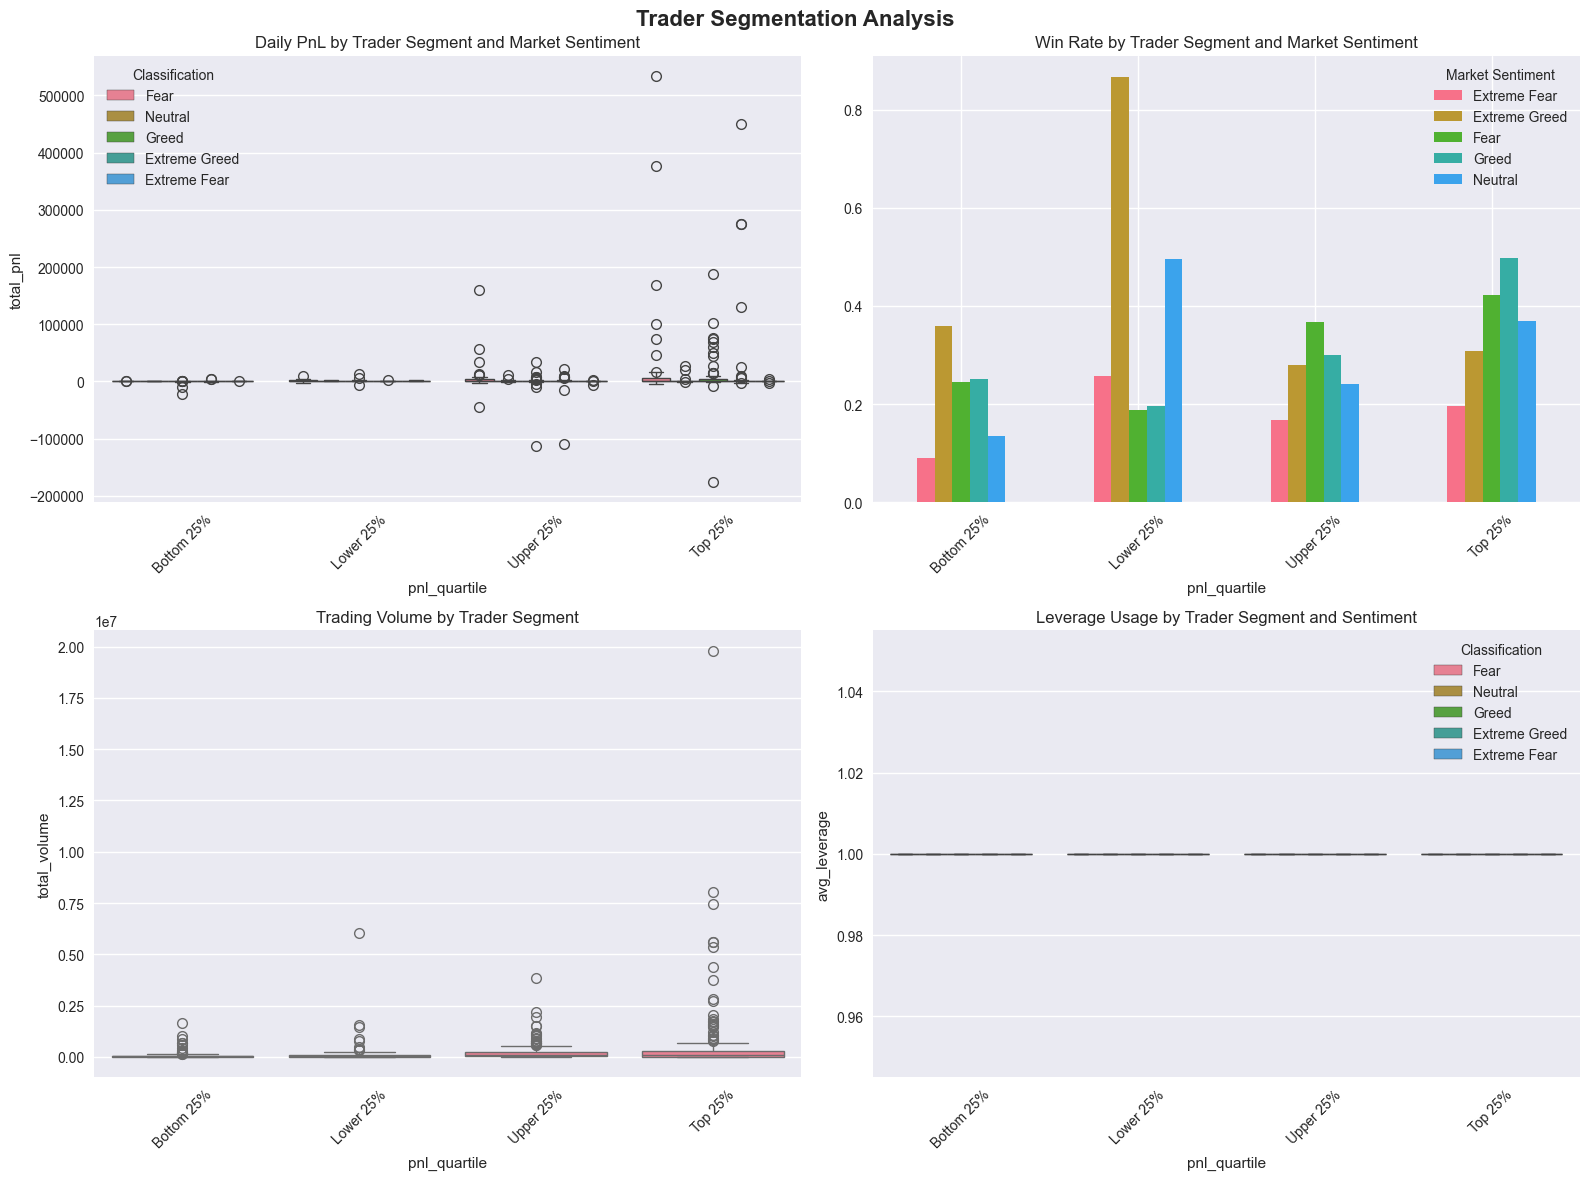


=== TOP 10 TRADERS BY CUMULATIVE PnL ===
                                   account  cumulative_pnl  avg_win_rate  total_volume  total_trades  avg_leverage pnl_quartile volume_quartile
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23    1.478495e+06      0.285302  2.661449e+07          5220           1.0      Top 25%   Very High Vol
0x083384f897ee0f19899168e3b1bec365f52a9012    9.655887e+05      0.421912  4.046554e+07          2486           1.0      Top 25%   Very High Vol
0xbee1707d6b44d4d52bfe19e41f8a828645437aab    2.056523e+05      0.507530  1.051671e+07          5715           1.0      Top 25%   Very High Vol
0xbaaaf6571ab7d571043ff1e313a9609a10637864    2.013539e+05      0.637450  1.163864e+07          2562           1.0      Top 25%   Very High Vol
0x72c6a4624e1dffa724e6d00d64ceae698af892a0    1.972949e+05      0.192889  7.332898e+05           283           1.0      Top 25%         Med Vol
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4    1.425837e+05      0.693401  8.577343e+06        

In [9]:
# Run this after Step 4
print("\n=== STEP 5: ADVANCED ANALYSIS & TRADER SEGMENTATION ===")
print("Performing trader segmentation and advanced analytics...")

try:
    # Identify top and bottom performers
    print("Analyzing top and bottom performers...")
    
    top_performers = merged_data.nlargest(10, 'total_pnl')[['account', 'total_pnl', 'win_rate', 'Classification', 'date']]
    bottom_performers = merged_data.nsmallest(10, 'total_pnl')[['account', 'total_pnl', 'win_rate', 'Classification', 'date']]
    
    print(f"\n=== TOP 10 DAILY PERFORMANCES ===")
    print(top_performers.to_string(index=False))
    
    print(f"\n=== BOTTOM 10 DAILY PERFORMANCES ===")
    print(bottom_performers.to_string(index=False))
    
    # Calculate trader-level metrics (aggregate by trader)
    print(f"\nCreating trader-level aggregations...")
    
    trader_metrics = merged_data.groupby('account').agg({
        'total_pnl': 'sum',
        'win_rate': 'mean',
        'total_volume': 'sum',
        'num_trades': 'sum',
        'avg_leverage': 'mean'
    }).reset_index()
    
    trader_metrics.columns = ['account', 'cumulative_pnl', 'avg_win_rate', 'total_volume', 'total_trades', 'avg_leverage']
    
    # Create trader segments based on performance
    trader_metrics['pnl_quartile'] = pd.qcut(trader_metrics['cumulative_pnl'], 4, labels=['Bottom 25%', 'Lower 25%', 'Upper 25%', 'Top 25%'])
    trader_metrics['volume_quartile'] = pd.qcut(trader_metrics['total_volume'], 4, labels=['Low Vol', 'Med Vol', 'High Vol', 'Very High Vol'])
    
    print(f" Trader segmentation completed!")
    print(f" Total unique traders: {len(trader_metrics)}")
    
    # Show segment distribution
    print(f"\n=== TRADER SEGMENT DISTRIBUTION ===")
    segment_counts = trader_metrics['pnl_quartile'].value_counts()
    for segment, count in segment_counts.items():
        print(f" {segment}: {count} traders")
    
    # Merge back with daily data for segment analysis
    trader_segments = merged_data.merge(trader_metrics[['account', 'pnl_quartile']], on='account')
    
    # Create segment analysis visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Trader Segmentation Analysis', fontsize=16, fontweight='bold')
    
    # PnL by trader segment and sentiment
    print(" Creating segment performance plots...")
    sns.boxplot(data=trader_segments, x='pnl_quartile', y='total_pnl', hue='Classification', ax=axes[0,0])
    axes[0,0].set_title('Daily PnL by Trader Segment and Market Sentiment')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Win rate by trader segment and sentiment
    win_rate_pivot = trader_segments.groupby(['pnl_quartile', 'Classification'])['win_rate'].mean().unstack()
    win_rate_pivot.plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('Win Rate by Trader Segment and Market Sentiment')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].legend(title='Market Sentiment')
    
    # Volume by segment
    sns.boxplot(data=trader_segments, x='pnl_quartile', y='total_volume', ax=axes[1,0])
    axes[1,0].set_title('Trading Volume by Trader Segment')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Leverage by segment and sentiment
    sns.boxplot(data=trader_segments, x='pnl_quartile', y='avg_leverage', hue='Classification', ax=axes[1,1])
    axes[1,1].set_title('Leverage Usage by Trader Segment and Sentiment')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Show top performers by cumulative PnL
    print(f"\n=== TOP 10 TRADERS BY CUMULATIVE PnL ===")
    top_traders = trader_metrics.nlargest(10, 'cumulative_pnl')
    print(top_traders.to_string(index=False))
    
    print(f"\n✓ STEP 5 COMPLETED SUCCESSFULLY!")
    
except Exception as e:
    print(f" Error in Step 5: {str(e)}")
    print("Please check the previous steps and try again.")

In [10]:
# Run this after Step 5
print("\n=== STEP 6: KEY INSIGHTS & TRADING RECOMMENDATIONS ===")
print("Generating strategic insights and actionable recommendations...")

try:
    # Calculate key performance metrics by sentiment
    print("Analyzing performance by market sentiment...")
    
    # Get sentiment-specific data
    sentiment_groups = merged_data.groupby('Classification')
    
    sentiment_analysis = {}
    for sentiment, group in sentiment_groups:
        sentiment_analysis[sentiment] = {
            'avg_pnl': group['total_pnl'].mean(),
            'median_pnl': group['total_pnl'].median(),
            'win_rate': group['win_rate'].mean(),
            'avg_volume': group['total_volume'].mean(),
            'avg_trades': group['num_trades'].mean(),
            'avg_leverage': group['avg_leverage'].mean(),
            'total_traders': group['account'].nunique(),
            'total_days': len(group)
        }
    
    print("\n" + "="*80)
    print("COMPREHENSIVE MARKET SENTIMENT ANALYSIS")
    print("="*80)
    
    for sentiment, metrics in sentiment_analysis.items():
        print(f"\n {sentiment.upper()} MARKET CONDITIONS:")
        print(f"   • Average Daily PnL per Trader: ${metrics['avg_pnl']:,.2f}")
        print(f"   • Median Daily PnL per Trader: ${metrics['median_pnl']:,.2f}")
        print(f"   • Average Win Rate: {metrics['win_rate']:.2%}")
        print(f"   • Average Daily Volume: ${metrics['avg_volume']:,.2f}")
        print(f"   • Average Trades per Day: {metrics['avg_trades']:.1f}")
        print(f"   • Average Leverage: {metrics['avg_leverage']:.2f}x")
        print(f"   • Total Trading Days: {metrics['total_days']}")
    
    # Compare sentiments
    sentiments = list(sentiment_analysis.keys())
    if len(sentiments) >= 2:
        s1, s2 = sentiments[0], sentiments[1]
        
        print(f"\n" + "="*80)
        print("COMPARATIVE ANALYSIS")
        print("="*80)
        
        pnl_diff = sentiment_analysis[s1]['avg_pnl'] - sentiment_analysis[s2]['avg_pnl']
        better_sentiment = s1 if pnl_diff > 0 else s2
        worse_sentiment = s2 if pnl_diff > 0 else s1
        
        print(f"\n PERFORMANCE WINNER: {better_sentiment}")
        print(f"   • Performance advantage: ${abs(pnl_diff):,.2f} per day")
        print(f"   • Relative improvement: {abs(pnl_diff)/abs(sentiment_analysis[worse_sentiment]['avg_pnl'])*100:.1f}%")
        
        win_rate_diff = sentiment_analysis[s1]['win_rate'] - sentiment_analysis[s2]['win_rate']
        if abs(win_rate_diff) > 0.01:  # 1% difference
            better_wr = s1 if win_rate_diff > 0 else s2
            print(f"   • Win rate advantage: {better_wr} (+{abs(win_rate_diff):.1%})")
    
    # Risk Analysis
    print(f"\n" + "="*80)
    print("RISK ANALYSIS")
    print("="*80)
    
    for sentiment, metrics in sentiment_analysis.items():
        group_data = merged_data[merged_data['Classification'] == sentiment]
        volatility = group_data['total_pnl'].std()
        max_loss = group_data['total_pnl'].min()
        max_gain = group_data['total_pnl'].max()
        
        print(f"\n  {sentiment.upper()} RISK METRICS:")
        print(f"   • PnL Volatility (Std Dev): ${volatility:,.2f}")
        print(f"   • Maximum Single Day Loss: ${max_loss:,.2f}")
        print(f"   • Maximum Single Day Gain: ${max_gain:,.2f}")
        print(f"   • Risk-Adjusted Return: {metrics['avg_pnl']/volatility:.3f}")
    
    # Trading Strategy Recommendations
    print(f"\n" + "="*80)
    print(" ACTIONABLE TRADING STRATEGY RECOMMENDATIONS")
    print("="*80)
    
    # Determine best performing sentiment
    best_sentiment = max(sentiment_analysis.keys(), key=lambda x: sentiment_analysis[x]['avg_pnl'])
    worst_sentiment = min(sentiment_analysis.keys(), key=lambda x: sentiment_analysis[x]['avg_pnl'])
    
    print(f"\n1.  SENTIMENT-BASED STRATEGY:")
    if sentiment_analysis[best_sentiment]['avg_pnl'] > 0:
        print(f"    INCREASE EXPOSURE during {best_sentiment} market conditions")
        print(f"    Average expected return: ${sentiment_analysis[best_sentiment]['avg_pnl']:,.2f}/day")
    
    if sentiment_analysis[worst_sentiment]['avg_pnl'] < 0:
        print(f"     REDUCE EXPOSURE during {worst_sentiment} market conditions")
        print(f"     Average expected loss: ${sentiment_analysis[worst_sentiment]['avg_pnl']:,.2f}/day")
    
    print(f"\n2.  RISK MANAGEMENT:")
    high_leverage_sentiment = max(sentiment_analysis.keys(), key=lambda x: sentiment_analysis[x]['avg_leverage'])
    low_leverage_sentiment = min(sentiment_analysis.keys(), key=lambda x: sentiment_analysis[x]['avg_leverage'])
    
    print(f"   • Traders use higher leverage ({sentiment_analysis[high_leverage_sentiment]['avg_leverage']:.2f}x) during {high_leverage_sentiment}")
    print(f"   • Lower leverage ({sentiment_analysis[low_leverage_sentiment]['avg_leverage']:.2f}x) during {low_leverage_sentiment}")
    
    if sentiment_analysis[high_leverage_sentiment]['avg_pnl'] < sentiment_analysis[low_leverage_sentiment]['avg_pnl']:
        print(f"     RECOMMENDATION: Reduce leverage during {high_leverage_sentiment} conditions")
    
    print(f"\n3.  VOLUME STRATEGY:")
    high_vol_sentiment = max(sentiment_analysis.keys(), key=lambda x: sentiment_analysis[x]['avg_volume'])
    print(f"   • Higher trading volume during {high_vol_sentiment} conditions")
    print(f"   • Consider liquidity management during high-volume periods")
    
    print(f"\n4.  FREQUENCY OPTIMIZATION:")
    high_freq_sentiment = max(sentiment_analysis.keys(), key=lambda x: sentiment_analysis[x]['avg_trades'])
    print(f"   • More frequent trading during {high_freq_sentiment} ({sentiment_analysis[high_freq_sentiment]['avg_trades']:.1f} trades/day)")
    print(f"   • Consider transaction costs in high-frequency periods")
    
    # Final Strategic Recommendation
    print(f"\n" + "="*80)
    print(" FINAL STRATEGIC RECOMMENDATION")
    print("="*80)
    
    if sentiment_analysis[best_sentiment]['avg_pnl'] > abs(sentiment_analysis[worst_sentiment]['avg_pnl']):
        strategy_type = "CONTRARIAN" if "Fear" in best_sentiment else "MOMENTUM"
        print(f"\n RECOMMENDED STRATEGY: {strategy_type}")
        print(f" OPTIMAL CONDITIONS: {best_sentiment} market sentiment")
        print(f" EXPECTED EDGE: ${sentiment_analysis[best_sentiment]['avg_pnl']:,.2f} per trading day")
        print(f" WIN RATE: {sentiment_analysis[best_sentiment]['win_rate']:.1%}")
    
    print(f"\n IMPLEMENTATION TIPS:")
    print(f"   1. Monitor market sentiment indicators daily")
    print(f"   2. Adjust position sizing based on sentiment conditions")
    print(f"   3. Set stricter risk controls during adverse sentiment periods")
    print(f"   4. Consider sentiment as a factor in your trading algorithm")
    
    print(f"\n STEP 6 COMPLETED SUCCESSFULLY!")
    print(f"\n COMPLETE ANALYSIS FINISHED!")
    print("="*80)
    
except Exception as e:
    print(f" Error in Step 6: {str(e)}")
    print("Please check the previous steps and try again.")


=== STEP 6: KEY INSIGHTS & TRADING RECOMMENDATIONS ===
Generating strategic insights and actionable recommendations...
Analyzing performance by market sentiment...

COMPREHENSIVE MARKET SENTIMENT ANALYSIS

 EXTREME FEAR MARKET CONDITIONS:
   • Average Daily PnL per Trader: $133.33
   • Median Daily PnL per Trader: $0.00
   • Average Win Rate: 17.35%
   • Average Daily Volume: $290,310.31
   • Average Trades per Day: 70.5
   • Average Leverage: 1.00x
   • Total Trading Days: 33

 EXTREME GREED MARKET CONDITIONS:
   • Average Daily PnL per Trader: $10,329.41
   • Median Daily PnL per Trader: $108.94
   • Average Win Rate: 33.59%
   • Average Daily Volume: $162,712.14
   • Average Trades per Day: 50.2
   • Average Leverage: 1.00x
   • Total Trading Days: 112

 FEAR MARKET CONDITIONS:
   • Average Daily PnL per Trader: $11,332.65
   • Median Daily PnL per Trader: $396.06
   • Average Win Rate: 34.99%
   • Average Daily Volume: $507,480.20
   • Average Trades per Day: 88.3
   • Average Lev

In [13]:
print("\n=== STEP 7: SAVE RESULTS & EXPORT DATA ===")
print("Saving analysis results to CSV files...")

try:
    # Save the main merged dataset
    results['merged_data'].to_csv('trader_sentiment_analysis_results.csv', index=False)
    print(" Saved: trader_sentiment_analysis_results.csv")
    
    # Save trader segments analysis
    results['trader_segments'].to_csv('trader_segments_analysis.csv', index=False)
    print(" Saved: trader_segments_analysis.csv")
    
    # Save daily sentiment statistics
    results['daily_stats'].to_csv('daily_sentiment_stats.csv', index=False)
    print(" Saved: daily_sentiment_stats.csv")
    
    print("\nAll results saved successfully!")

except Exception as e:
    print(f" Error while saving CSV files: {e}")



=== STEP 7: SAVE RESULTS & EXPORT DATA ===
Saving analysis results to CSV files...
 Saved: trader_sentiment_analysis_results.csv
 Saved: trader_segments_analysis.csv
 Saved: daily_sentiment_stats.csv

All results saved successfully!
